
# # Few-Shot Learning on Oxford 102 Flower Dataset
- The main code was implemented with Tensorflow framework
# 
# This notebook implements few-shot learning using:
# - 3-way, 3-shot learning setup
# - ResNet50 as feature extractor
# - Contrastive loss
# - Fine-tuning of dense layers
# - Support set and query set implementation

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

## Load Dataset

In [2]:
(train_ds, val_ds, test_ds), info = tfds.load(
    'oxford_flowers102',
    split=['train', 'validation', 'test'],
    with_info=True,
    as_supervised=True
)

label_names = info.features['label'].names

print(f"Total classes: {info.features['label'].num_classes}")
print(f"Train size: {info.splits['train'].num_examples}")
print(f"Validation size: {info.splits['validation'].num_examples}")
print(f"Test size: {info.splits['test'].num_examples}")

Total classes: 102
Train size: 1020
Validation size: 1020
Test size: 6149


## Visualize Dataset Samples

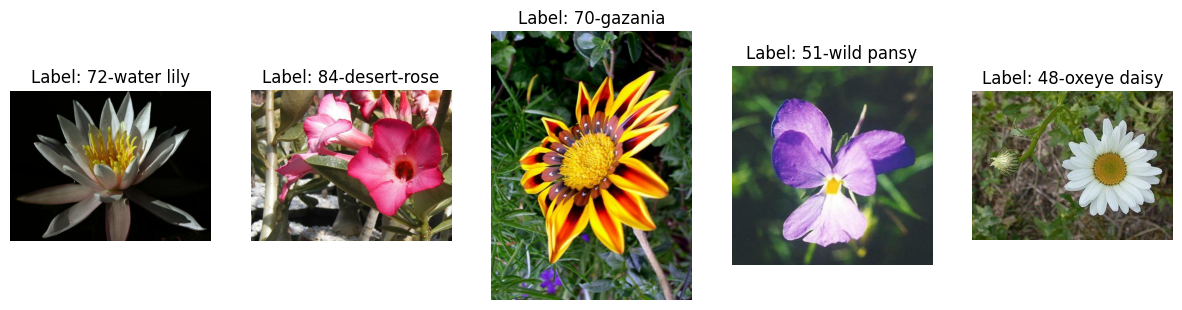

In [3]:
# Function to plot samples
def plot_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.numpy())
        plt.title(f"Label: {label.numpy()}-{label_names[label.numpy()]}")
        plt.axis("off")
    plt.show()

# Plot samples from train set
plot_samples(train_ds, num_samples=5)

# Preprocessing

In [4]:
def preprocess_image(image, label):
    """Preprocess images for ResNet50"""
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))  # ResNet50 input size
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

# Apply preprocessing to datasets
train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)

# Cache the datasets for better performance
train_ds = train_ds.cache().shuffle(1000)
val_ds = val_ds.cache()
test_ds = test_ds.cache()



## Feature Extractor Model

In [5]:
def create_feature_extractor():
    """Create ResNet50 feature extractor with trainable dense layers"""
    # Load ResNet50 with pre-trained weights
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze all layers except the last few
    for layer in base_model.layers[:-2]:
        layer.trainable = False
    
    # Add custom layers with L2 normalization
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='dense1')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='dense2')(x)
    outputs = tf.keras.layers.BatchNormalization()(outputs)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the feature extractor
feature_extractor = create_feature_extractor()
feature_extractor.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,771,200 (94.49 MB)

 Trainable params: 1,181,952 (4.51 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

## Contrastive Loss

The contrastive loss is commonly used in Siamese networks to measure the similarity between two feature representations. It is defined as:

$$
\mathcal{L} = \frac{1}{2} (1 - Y) D^2 + \frac{1}{2} Y \max(0, m - D)^2
$$


where:
- \( Y \) is 0 if the pair is similar and 1 if the pair is dissimilar,
- \( D \) is the Euclidean distance between the feature embeddings,
- \( m \) is the margin that defines how far apart dissimilar pairs should be.



In [6]:

class ContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def call(self, y_true, embeddings):
        """
        Compute contrastive loss.
        Args:
        - y_true: (batch_size, 1) Tensor with 0 (same class) or 1 (different class).
        - embeddings: (batch_size, embedding_dim) Tensor of feature vectors.
        """
        # Compute pairwise Euclidean distance
        squared_diff = tf.reduce_sum(tf.square(embeddings[:, None] - embeddings[None, :]), axis=-1)
        distances = tf.sqrt(squared_diff + 1e-8)  # Adding epsilon for numerical stability
        
        # Compute contrastive loss
        positive_pairs = (1 - y_true) * tf.square(distances)
        negative_pairs = y_true * tf.square(tf.maximum(self.margin - distances, 0))
        
        loss = 0.5 * (positive_pairs + negative_pairs)
        
        return tf.reduce_mean(loss)


## Few-Shot Learning Implementation

In [7]:
class FewShotLearner:
   
    def __init__(self, n_way=3, n_shot=3, n_query=4):
       
        self.n_way = n_way
        self.n_shot = n_shot
        self.n_query = n_query
        self.feature_extractor = create_feature_extractor()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.contrastive_loss = ContrastiveLoss()
    
    def create_episode(self, dataset):
        """Create a few-shot episode from the dataset"""
        # Convert dataset to numpy for easier manipulation
        images, labels = [], []
        for img, lbl in dataset.take(1000):  # Take a subset for efficiency
            images.append(img.numpy())
            labels.append(lbl.numpy())
        
        images = np.array(images)
        labels = np.array(labels)
        
        # Randomly select n_way classes
        unique_labels = np.unique(labels)
        
        # Ensure we have enough classes
        if len(unique_labels) < self.n_way:
            print(f"Warning: Not enough classes. Found {len(unique_labels)}, need {self.n_way}")
            return None, None, None, None
        
        selected_classes = np.random.choice(unique_labels, self.n_way, replace=False)
        
        support_images, support_labels = [], []
        query_images, query_labels = [], []
        valid_classes = 0
        
        for idx, cls in enumerate(selected_classes):
            # Get all images of this class
            cls_images = images[labels == cls]
            
            # Ensure we have enough samples
            if len(cls_images) < (self.n_shot + self.n_query):
                continue
                
            # Randomly select samples
            selected_indices = np.random.choice(
                len(cls_images),
                self.n_shot + self.n_query,
                replace=False
            )
            
            # Split into support and query
            support_idx = selected_indices[:self.n_shot]
            query_idx = selected_indices[self.n_shot:]
            
            support_images.extend(cls_images[support_idx])
            support_labels.extend([valid_classes] * self.n_shot)
            
            query_images.extend(cls_images[query_idx])
            query_labels.extend([valid_classes] * self.n_query)
            
            valid_classes += 1
        
        # Check if we have enough valid classes
        if valid_classes < self.n_way:
            print(f"Warning: Not enough valid classes. Found {valid_classes}, need {self.n_way}")
            return None, None, None, None
        
        if not support_images or not query_images:
            print("Warning: No valid episodes created")
            return None, None, None, None
            
        return (
            np.array(support_images),
            np.array(support_labels),
            np.array(query_images),
            np.array(query_labels)
        )
    
    @tf.function
    def train_step(self, support_images, support_labels, query_images, query_labels):
        """Perform one training step"""
        with tf.GradientTape() as tape:
            # Get embeddings for support and query images
            support_embeddings = self.feature_extractor(support_images, training=True)
            query_embeddings = self.feature_extractor(query_images, training=True)
            
            # Combine embeddings and labels
            all_embeddings = tf.concat([support_embeddings, query_embeddings], axis=0)
            all_labels = tf.concat([support_labels, query_labels], axis=0)

            # Create pairwise label matrix
            y_true = 1 - tf.cast(tf.equal(tf.expand_dims(all_labels, 0), tf.expand_dims(all_labels, 1)), tf.float32)


            # Calculate loss
            loss = self.contrastive_loss(y_true, all_embeddings)

        # Calculate gradients and update model
        gradients = tape.gradient(loss, self.feature_extractor.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.feature_extractor.trainable_variables))

        return loss
        
    def compute_accuracy(self, support_images, support_labels, query_images, query_labels):
        """Compute accuracy for the episode"""
        # Check for valid inputs
        if support_images is None or query_images is None:
            return 0.0
            
        if len(support_images) == 0 or len(query_images) == 0:
            return 0.0
            
        try:
            # Get embeddings
            support_embeddings = self.feature_extractor.predict(support_images, verbose=0)
            query_embeddings = self.feature_extractor.predict(query_images, verbose=0)
            
            # Compute prototypes for each class
            prototypes = []
            for i in range(self.n_way):
                class_mask = support_labels == i
                if np.any(class_mask):  # Check if we have any samples for this class
                    prototype = tf.reduce_mean(
                        support_embeddings[class_mask],
                        axis=0
                    )
                    prototypes.append(prototype)
            
            if not prototypes:  # If no valid prototypes were created
                return 0.0
                
            prototypes = np.array(prototypes)
            
            # Calculate distances to prototypes
            distances = []
            for prototype in prototypes:
                distance = np.sum((query_embeddings - prototype) ** 2, axis=1)
                distances.append(distance)
            distances = np.array(distances)
            
            # Get predictions
            predictions = np.argmin(distances, axis=0)
            
            # Calculate accuracy
            accuracy = np.mean(predictions == query_labels)
            return accuracy
            
        except Exception as e:
            print(f"Error in compute_accuracy: {str(e)}")
            return 0.0

## Training Loop

In [8]:
fsl = FewShotLearner(n_way=3, n_shot=3, n_query=4)

# Training parameters
n_episodes = 500
eval_interval = 50

# Training history
train_losses = []
val_accuracies = []

for episode in range(n_episodes):
    # Create training episode
    support_images, support_labels, query_images, query_labels = fsl.create_episode(train_ds)
    
    # Training step
    loss = fsl.train_step(
        tf.convert_to_tensor(support_images),
        tf.convert_to_tensor(support_labels),
        tf.convert_to_tensor(query_images),
        tf.convert_to_tensor(query_labels)
    )
    
    train_losses.append(loss.numpy())
    
    # Evaluation
    if (episode + 1) % eval_interval == 0:
        # Create validation episode
        val_support_images, val_support_labels, val_query_images, val_query_labels = \
            fsl.create_episode(val_ds)
        
        # Compute accuracy
        accuracy = fsl.compute_accuracy(
            val_support_images,
            val_support_labels,
            val_query_images,
            val_query_labels
        )
        
        val_accuracies.append(accuracy)
        
        print(f"Episode {episode + 1}/{n_episodes}")
        print(f"Loss: {loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.4f}\n")
        

# Save the trained model
fsl.feature_extractor.save("few_shot_feature_extractor.h5")

Episode 50/500
Loss: 40.3902
Validation Accuracy: 0.8333

Episode 100/500
Loss: 21.1521
Validation Accuracy: 0.5833

Episode 150/500
Loss: 67.0970
Validation Accuracy: 1.0000

Episode 200/500
Loss: 6.4753
Validation Accuracy: 0.6667

Episode 250/500
Loss: 54.9649
Validation Accuracy: 0.7500

Episode 300/500
Loss: 12.7433
Validation Accuracy: 0.7500

Episode 350/500
Loss: 14.6303
Validation Accuracy: 0.7500

Episode 400/500
Loss: 5.8505
Validation Accuracy: 0.4167

Episode 450/500
Loss: 40.7345
Validation Accuracy: 0.8333



Episode 500/500
Loss: 15.5923
Validation Accuracy: 0.6667



## Visualize Results

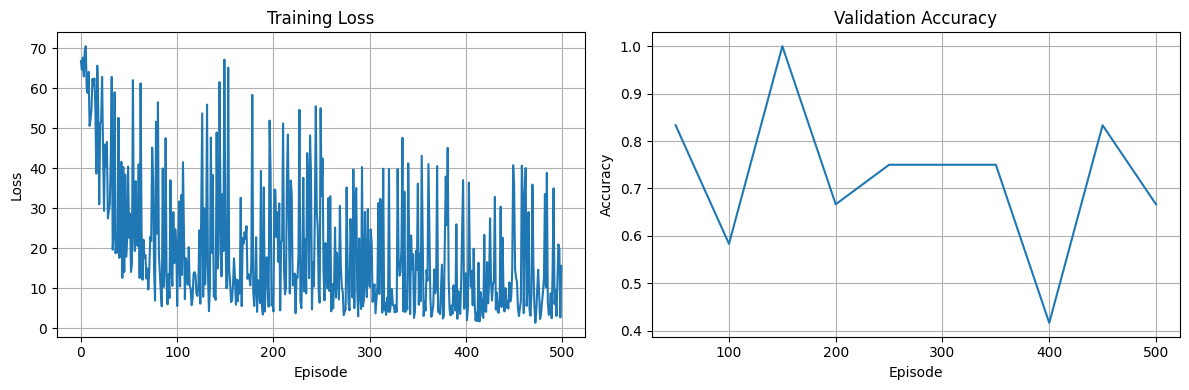

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(eval_interval, n_episodes + 1, eval_interval), val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Episode')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
n_test_episodes = 100
test_accuracies = []
max_attempts = 200  # Allow more attempts if needed

episode = 0
attempts = 0

while episode < n_test_episodes and attempts < max_attempts:
    # Create test episode
    support_images, support_labels, query_images, query_labels = fsl.create_episode(test_ds)
    
    # Skip invalid episodes
    if support_images is None or query_images is None:
        attempts += 1
        print(f"Skipping invalid episode {attempts}/{max_attempts}")
        continue
    
    # Compute accuracy
    accuracy = fsl.compute_accuracy(
        support_images,
        support_labels,
        query_images,
        query_labels
    )
    
    # Only count valid accuracies
    if accuracy > 0:
        test_accuracies.append(accuracy)
        episode += 1
    
    attempts += 1

# Display results
if test_accuracies:
    print(f"Average Test Accuracy: {np.mean(test_accuracies):.4f} ± {np.std(test_accuracies):.4f}")
    print(f"Valid episodes: {len(test_accuracies)}/{n_test_episodes}")
else:
    print("No valid episodes were created for testing")


Skipping invalid episode 1/200
Skipping invalid episode 2/200
Skipping invalid episode 4/200
Skipping invalid episode 5/200
Skipping invalid episode 6/200
Skipping invalid episode 7/200
Skipping invalid episode 8/200
Skipping invalid episode 10/200
Skipping invalid episode 11/200
Skipping invalid episode 12/200
Skipping invalid episode 13/200
Skipping invalid episode 14/200
Skipping invalid episode 15/200
Skipping invalid episode 17/200
Skipping invalid episode 19/200
Skipping invalid episode 20/200
Skipping invalid episode 21/200
Skipping invalid episode 23/200
Skipping invalid episode 24/200
Skipping invalid episode 25/200
Skipping invalid episode 26/200
Skipping invalid episode 27/200
Skipping invalid episode 28/200
Skipping invalid episode 29/200
Skipping invalid episode 30/200
Skipping invalid episode 31/200
Skipping invalid episode 32/200
Skipping invalid episode 33/200
Skipping invalid episode 34/200
Skipping invalid episode 35/200
Skipping invalid episode 36/200
Skipping invali

## Plot Accuracy Over Test Episodes

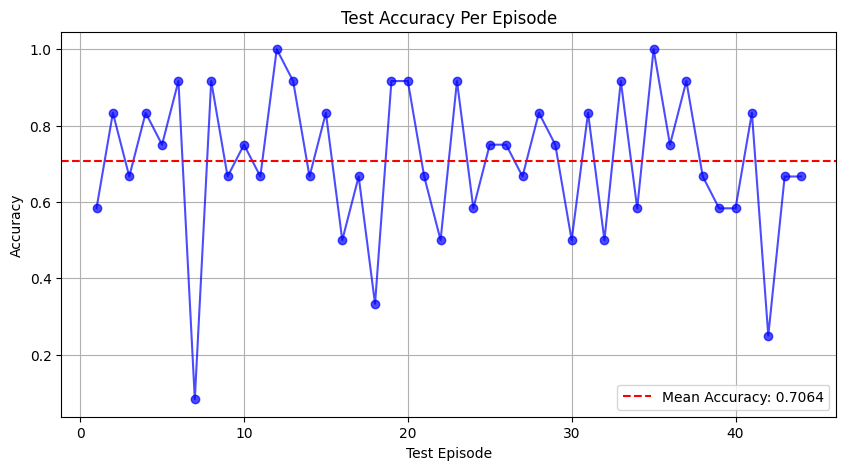

In [11]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-', color='b', alpha=0.7)
plt.axhline(y=np.mean(test_accuracies), color='r', linestyle='--', label=f"Mean Accuracy: {np.mean(test_accuracies):.4f}")
plt.xlabel("Test Episode")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Per Episode")
plt.legend()
plt.grid(True)
plt.show()


Visualizing few-shot predictions on test set:
Could not create valid episode
Could not create valid episode


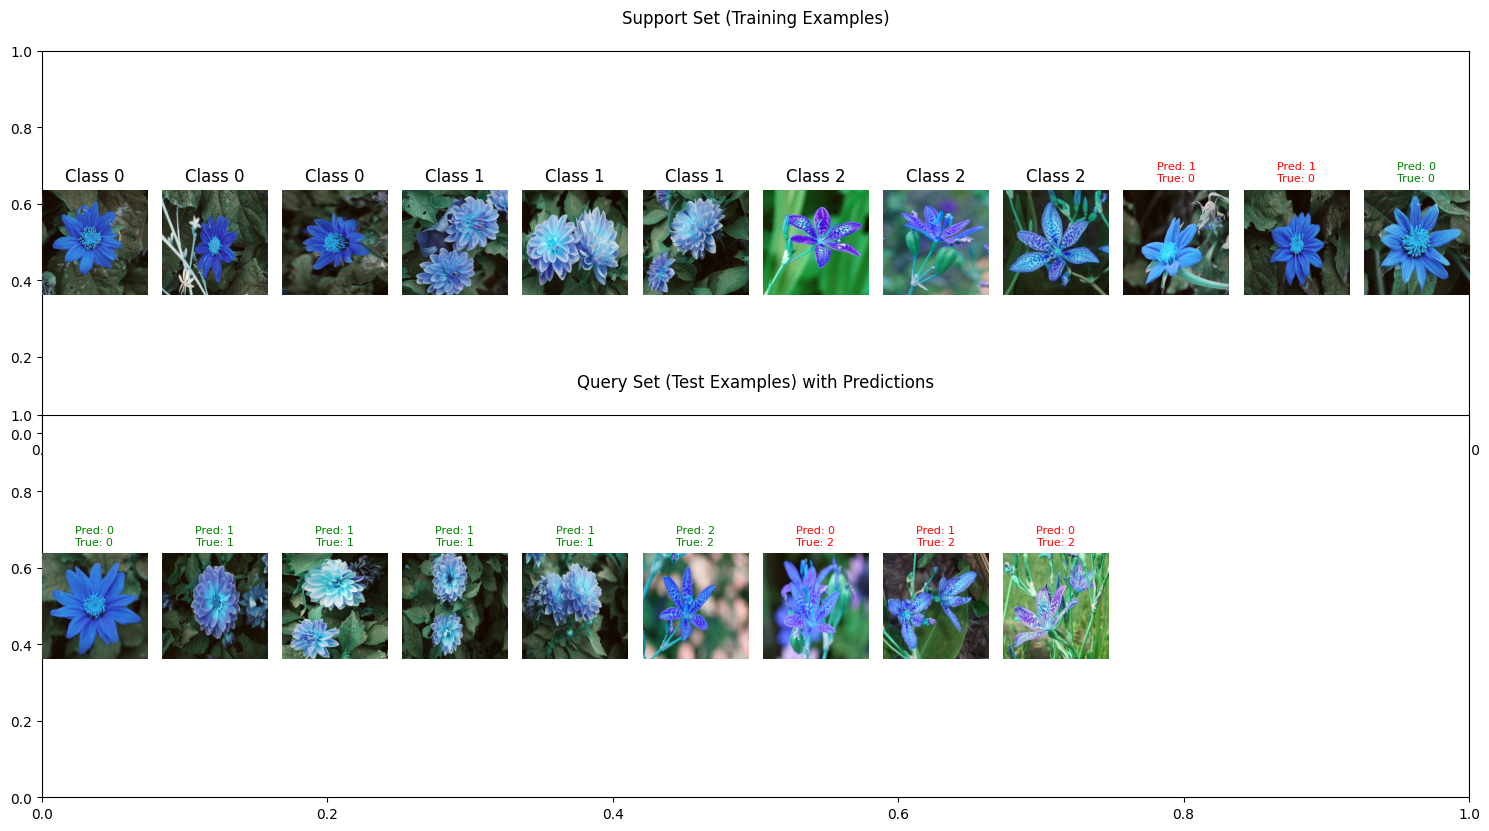

Episode 3 Accuracy: 0.5833
Could not create valid episode


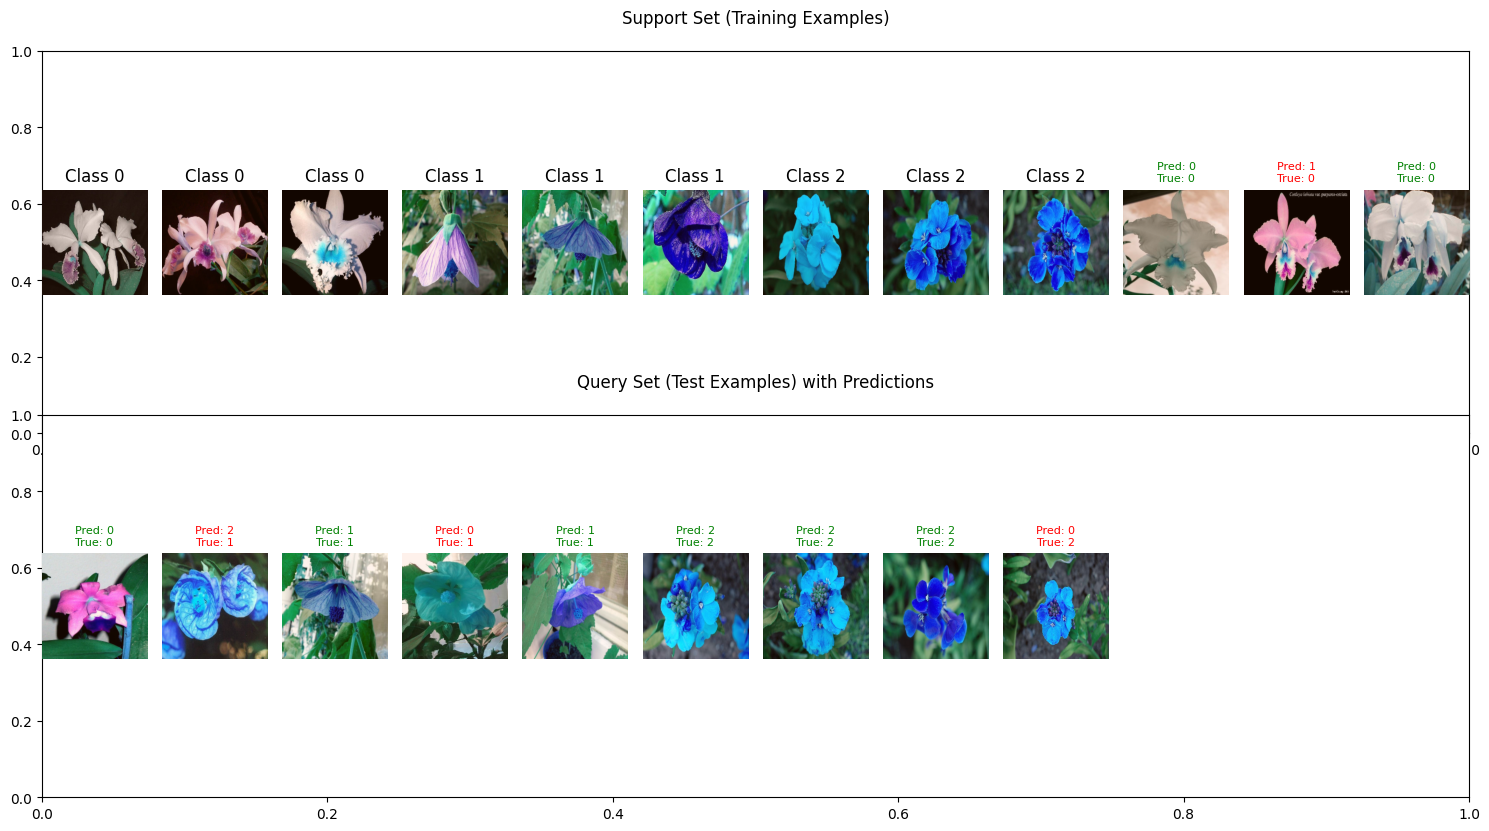

Episode 5 Accuracy: 0.6667


In [12]:
def visualize_few_shot_predictions(fsl, test_ds, num_episodes=3):
    """Visualize few-shot predictions on test set"""
    for episode in range(num_episodes):
        # Create test episode
        support_images, support_labels, query_images, query_labels = fsl.create_episode(test_ds)
        
        if support_images is None or query_images is None:
            print("Could not create valid episode")
            continue
            
        # Get predictions
        support_embeddings = fsl.feature_extractor.predict(support_images, verbose=0)
        query_embeddings = fsl.feature_extractor.predict(query_images, verbose=0)
        
        # Compute prototypes for each class
        prototypes = []
        for i in range(fsl.n_way):
            prototype = tf.reduce_mean(
                support_embeddings[support_labels == i],
                axis=0
            )
            prototypes.append(prototype)
        prototypes = np.array(prototypes)
        
        # Get predictions
        distances = []
        for prototype in prototypes:
            distance = np.sum((query_embeddings - prototype) ** 2, axis=1)
            distances.append(distance)
        distances = np.array(distances)
        predictions = np.argmin(distances, axis=0)
        
        # Visualization
        plt.figure(figsize=(15, 8))
        
        # Plot support set
        plt.subplot(2, 1, 1)
        plt.title('Support Set (Training Examples)', pad=20)
        for i in range(fsl.n_way):
            for j in range(fsl.n_shot):
                idx = i * fsl.n_shot + j
                plt.subplot(2, max(fsl.n_way * fsl.n_shot, len(query_images)), idx + 1)
                
                # Convert image for display
                img = support_images[idx]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                plt.imshow(img)
                plt.axis('off')
                plt.title(f'Class {support_labels[idx]}')
        
        # Plot query set with predictions
        plt.subplot(2, 1, 2)
        plt.title('Query Set (Test Examples) with Predictions', pad=20)
        for i in range(len(query_images)):
            plt.subplot(2, max(fsl.n_way * fsl.n_shot, len(query_images)), 
                       fsl.n_way * fsl.n_shot + i + 1)
            
            # Convert image for display
            img = query_images[i]
            img = (img - np.min(img)) / (np.max(img) - np.min(img))
            
            plt.imshow(img)
            plt.axis('off')
            
            # Color code the predictions (green for correct, red for wrong)
            color = 'green' if predictions[i] == query_labels[i] else 'red'
            plt.title(f'Pred: {predictions[i]}\nTrue: {query_labels[i]}', 
                     color=color, fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
        # Print accuracy for this episode
        accuracy = np.mean(predictions == query_labels)
        print(f"Episode {episode + 1} Accuracy: {accuracy:.4f}")

# Visualize predictions on test set
print("\nVisualizing few-shot predictions on test set:")
visualize_few_shot_predictions(fsl, test_ds, num_episodes=5)

## Visualize Feature Embeddings (t-SNE)

In [13]:
from sklearn.manifold import TSNE

def visualize_embeddings(feature_extractor, images, labels, method='tsne', perplexity=10):
    """
    Visualize embeddings in 2D using t-SNE or UMAP.
    
    Args:
        feature_extractor: Trained model to compute embeddings.
        images: Array of images to visualize.
        labels: Array of labels corresponding to images.
        method: 'tsne' or 'umap' for dimensionality reduction.
        perplexity: Perplexity parameter for t-SNE (should be less than n_samples).
    """
    # Compute embeddings
    embeddings = feature_extractor.predict(images, verbose=0)
    
    # Dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == 'umap':
        import umap
        reducer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be either 'tsne' or 'umap'")
    
    embeddings_2d = reducer.fit_transform(embeddings)
    
    # Plot embeddings
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                          c=labels, cmap='jet', alpha=0.7)
    plt.title(f"Embedding Visualization using {method.upper()}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.colorbar(scatter, label='Class Label')
    plt.show()




